In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
from pyspark.sql import SparkSession 
spark = SparkSession.builder.getOrCreate()

In [3]:

Data_dir = "D:/recommender_systems/movie"

In [4]:
import os
import pyspark.sql.functions as F

In [5]:
ratings = (
    spark
    .read
    .csv(
        os.path.join(Data_dir, "ratings.csv"),
        header = True,
        inferSchema = True 
    )
    .sample(withReplacement = False, fraction = 0.1, seed = 0)    
    .withColumn("rating_datetime", F.from_unixtime("timestamp"))
    .drop("timestamp")
    )

In [6]:
print("Всего пользователей: ", ratings.select("userID").distinct().count())
print("Всего фильмов: ", ratings.select("movieId").distinct().count())
print("Всего оценок:  ", ratings.count())

Всего пользователей:  229690
Всего фильмов:  26221
Всего оценок:   2601951


In [7]:
mean_rating = ratings.agg(F.avg("rating")).first()[0]
print("Средняя оценка: ", mean_rating)


Средняя оценка:  3.527088519345676


In [8]:
from pyspark.sql import DataFrame

In [9]:
def simple_evaluate(predictions_df: DataFrame) -> float:
    return np.sqrt(
            ratings
            .join(
                predictions_df, 
                ["movieId", "userId", "rating"]
            ).select(
                F.pow(
                    ratings.rating - predictions_df.prediction,
                    2
                ).alias("squared_error")
            )
            .agg(F.avg("squared_error"))
            .first()[0]
    )

In [10]:
def simple_evaluate2(predictions_df: DataFrame) -> float:
    return np.sqrt(
            ratings
            .join(
                predictions_df, 
                ["movieId", "userId"]
            ).select(
                F.pow(
                    ratings.rating - predictions_df.prediction,
                    2
                ).alias("squared_error")
            )
            .agg(F.avg("squared_error"))
            .first()[0]
    )

In [11]:
mean_predictions = ratings.withColumn("prediction", F.lit(mean_rating))

In [12]:
print("Ошибка предсказания: ", simple_evaluate(mean_predictions))

Ошибка предсказания:  1.0658290201447025


In [13]:
movie_ratings = (
                ratings 
                .groupBy("movieId")
                .agg(F.avg("rating").alias("avg_movie_rating"))
                .cache()
)

In [14]:
movie_ratings.show()

+-------+------------------+
|movieId|  avg_movie_rating|
+-------+------------------+
|   1580|3.5595408895265424|
|    471|3.6117363344051445|
|   1088| 3.245185185185185|
|   1959|  3.63614262560778|
|   3175|3.5830367734282325|
|   2142| 2.946360153256705|
|   1645| 3.512127512127512|
|  54190| 3.635321100917431|
|   2366| 3.512295081967213|
|  44022|3.3390243902439023|
|   1591| 2.621187800963082|
|   8638|3.9571713147410357|
|   5803| 2.716417910447761|
|   1342| 2.875661375661376|
|   6466| 3.659090909090909|
|    496|3.1363636363636362|
|   4519| 3.248062015503876|
|  96488|3.9342105263157894|
|  68135|3.1365638766519823|
|   3794|3.3908045977011496|
+-------+------------------+
only showing top 20 rows



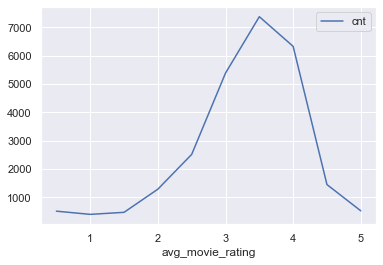

In [15]:
histogram = ( 
    movie_ratings
    .select((0.5 * F.ceil(2 * F.col("avg_movie_rating")))
    .alias("avg_movie_rating"))
    .groupBy("avg_movie_rating")
    .agg(F.count("avg_movie_rating").alias("cnt"))
    .orderBy("avg_movie_rating")
    .toPandas()
)
sns.set()
histogram.plot(x = "avg_movie_rating", y = "cnt")
plt.show()

In [16]:
avg_movie_rating_prediction = (
    ratings
    .join(movie_ratings, "movieId")
    .select(
        ratings.movieId,
        ratings.userId,
        ratings.rating,
        movie_ratings.avg_movie_rating.alias("prediction")
    )    
)


In [17]:
avg_movie_rating_prediction.show()

+-------+------+------+------------------+
|movieId|userId|rating|        prediction|
+-------+------+------+------------------+
|    858|     1|   5.0| 4.343411952473843|
|   4226|     1|   4.0| 4.160517489218974|
|  68358|     1|   5.0|3.8830532212885154|
| 112552|     1|   5.0| 4.028606965174129|
|   1356|     2|   5.0| 3.658658204895739|
|   3101|     3|   3.0|3.4459561602418747|
|   4474|     3|   3.0| 3.070945945945946|
|   1422|     4|   4.0| 3.145631067961165|
|   2443|     4|   4.0|3.4398496240601504|
|   2875|     4|   4.0|3.1209302325581394|
|   4014|     4|   4.0| 3.699155794320798|
|    858|     5|   5.0| 4.343411952473843|
|   1945|     5|   5.0|  4.18287037037037|
|   2707|     5|   5.0|3.4407894736842106|
|   3198|     5|   4.0| 3.948374760994264|
|   1198|     6|   3.0| 4.130514705882353|
|   8961|     7|   2.5| 3.857924461701377|
|  50872|     7|   4.0|3.8106595995288575|
|  54503|     7|   3.5|3.7136237256719182|
|  60074|     7|   1.0| 3.165402124430956|
+-------+--

In [18]:
print("Ошибка предсказания: ", simple_evaluate(avg_movie_rating_prediction))

Ошибка предсказания:  0.9571532518987653


In [19]:
user_ratings = (
    ratings
    .groupBy("userId")
    .agg(F.avg("rating").alias("avg_user_rating"))
    .cache()
)

In [20]:
user_ratings.show()

+------+------------------+
|userId|   avg_user_rating|
+------+------------------+
|   148|               3.7|
|   463|2.7777777777777777|
|   471|3.5789473684210527|
|  1088|               5.0|
|  1238| 4.166666666666667|
|  1342|               3.5|
|  1580|               0.5|
|  1591| 4.333333333333333|
|  1645|3.0714285714285716|
|  1829|               3.7|
|  1959|               3.0|
|  2142|               5.0|
|  2366| 3.725806451612903|
|  2659|              4.04|
|  2866|               3.5|
|  3175|               4.0|
|  3794| 4.818181818181818|
|  3918|               4.0|
|  3997|4.0588235294117645|
|  4101|               4.0|
+------+------------------+
only showing top 20 rows



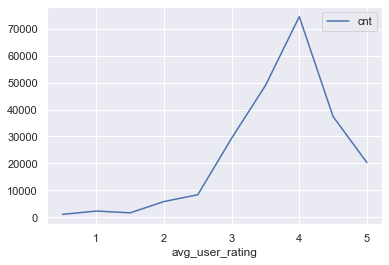

In [21]:
histogram = ( 
    user_ratings
    .select((0.5 * F.ceil(2 * F.col("avg_user_rating")))
    .alias("avg_user_rating"))
    .groupBy("avg_user_rating")
    .agg(F.count("avg_user_rating").alias("cnt"))
    .orderBy("avg_user_rating")
    .toPandas()
)
sns.set()
histogram.plot(x = "avg_user_rating", y = "cnt")
plt.show()

In [22]:
two_means_prediction = (
    ratings
    .join(user_ratings, "userId")
    .join(movie_ratings, "movieId")
    .select(
        ratings.movieId,
        ratings.userId,
        ratings.rating,       
        (0.5*(user_ratings.avg_user_rating + movie_ratings.avg_movie_rating)).alias("prediction"))
    )
two_means_prediction.show()  

+-------+------+------+------------------+
|movieId|userId|rating|        prediction|
+-------+------+------+------------------+
|    858|     1|   5.0| 4.546705976236922|
|   4226|     1|   4.0| 4.455258744609488|
|  68358|     1|   5.0|4.3165266106442575|
| 112552|     1|   5.0|4.3893034825870645|
|   1356|     2|   5.0| 4.329329102447869|
|   3101|     3|   3.0|3.2229780801209373|
|   4474|     3|   3.0| 3.035472972972973|
|   1422|     4|   4.0|3.5728155339805827|
|   2443|     4|   4.0| 3.719924812030075|
|   2875|     4|   4.0|3.5604651162790697|
|   4014|     4|   4.0|3.8495778971603993|
|    858|     5|   5.0| 4.546705976236922|
|   1945|     5|   5.0| 4.466435185185185|
|   2707|     5|   5.0| 4.095394736842105|
|   3198|     5|   4.0| 4.349187380497132|
|   1198|     6|   3.0|3.5652573529411766|
|   8961|     7|   2.5| 3.303962230850688|
|  50872|     7|   4.0| 3.280329799764429|
|  54503|     7|   3.5| 3.231811862835959|
|  60074|     7|   1.0|2.9577010622154782|
+-------+--

In [23]:
print("Ошибка предсказания: ", simple_evaluate(two_means_prediction))

Ошибка предсказания:  0.8773694669875353


In [24]:
kol_users_month = (
    ratings
    .select(
        "userId",
        F.year("rating_datetime").alias("year"),
        F.month("rating_datetime").alias("month")    
    )
    .groupBy("month", "year")
    .agg(F.countDistinct("userId").alias("colUsers"))
    .orderBy("month", "year")
    .toPandas()
)

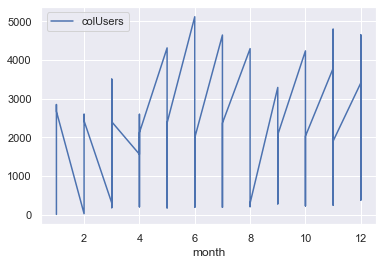

In [25]:

sns.set()
kol_users_month.plot(x = "month", y = "colUsers")
plt.show()

In [26]:
kol_users_month2 = (
    ratings
    .select(
        "userId",
        F.month("rating_datetime").alias("month")    
    )
    .groupBy("month")
    .agg(F.countDistinct("userId").alias("colUsers"))
    .orderBy("month")
    .toPandas()
)

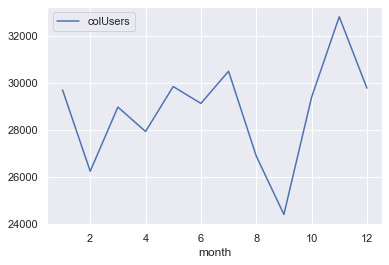

In [27]:
sns.set()
kol_users_month2.plot(x = "month", y = "colUsers")
plt.show()

In [28]:
kol_users_month.head(20)

,month,year,colUsers
0,1,1996,5
1,1,1997,2694
2,1,1998,467
3,1,1999,373
4,1,2000,2431
5,1,2001,2108
6,1,2002,1825
7,1,2003,1972
8,1,2004,1596
9,1,2005,1856


In [29]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

In [30]:
train = (
    VectorAssembler(
        inputCols = ("avg_movie_rating", "avg_user_rating"),
        outputCol = "features"
    ).transform(
        ratings
        .join(movie_ratings, "movieId")
        .join(user_ratings, "userId")
    )
    .withColumnRenamed("rating", "label")
    .select("movieId", "userId", "label", "features")
    .cache()
    )


linear_model = LinearRegression().fit(train)
stacked_prediction = (
    ratings
    .join(linear_model.transform(train), ["movieId", "userId"])
    .select("movieId", "userId", "prediction")
)

print("Ошибка предсказания", simple_evaluate2(stacked_prediction))


Ошибка предсказания 0.8360749293039146


In [1]:
import re

In [38]:
print(
    "На сколько наш пользователь оценит фильм = {} + {} * Средняя оценка этого фильма + {} * Средняя оценка пользователя"
    .format(
        round(linear_model.intercept, 2),
        round(linear_model.coefficients[0], 2),
        round(linear_model.coefficients[1], 2)   
    )
)

На сколько наш пользователь оценит фильм = -2.33 + 0.8 * Средняя оценка этого фильма + 0.86 * Средняя оценка пользователя
